# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Luis Saez Diaz
+ Erwin Nuñez Bracho

**Correos Electrónicos:**

+ lu.saezd@duocuc.cl
+ er.nunez@duocuc.cl

**Fecha de Creación:** 07 de Abril de 2025  
**Versión:** 0.5  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python, keras y tensorflow para el manejo de las redes neuronales y el matplotlib para la creacion de graficos con python.

# Carga de datos

In [10]:
!rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
!wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz


--2025-04-10 19:59:04--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.207, 74.125.141.207, 173.194.210.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  27.6MB/s    in 0.3s    

2025-04-10 19:59:05 (27.6 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-04-10 19:59:05--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.139.207, 74.125.141.207, 173.194.210.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.139.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [appli

In [11]:
!ls -lh

total 12M
drwxr-xr-x 1 root root 4.0K Apr  9 13:38 sample_data
-rw-r--r-- 1 root root 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 9.5M Apr  6  2017 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root  29K Apr  6  2017 train-labels-idx1-ubyte.gz


In [12]:
import gzip
import shutil
import struct
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical

# Carga de imágenes

In [13]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


La cantidad de datos en la muestra de entrenamiento es de 60.000 datos,
al vectorizarlos (aplanar) nos queda que las imagenes representan 784 pixeles vectorizados. En el caso de nuestra muestra de evaluación tenemos 10.000
con la misma cantidad de pixeles vectorizados y en el caso de las etiquetas tenemos que son 10.

Posteriormente a la carga los datos son normalizados, re-ajustando sus valores en valores de 0 a 255 lo que permite que todos mantengan un mismo rango de valores (formato) y no hayas valores que se disparen a diferencia de los demas.

# Muestra imágenes

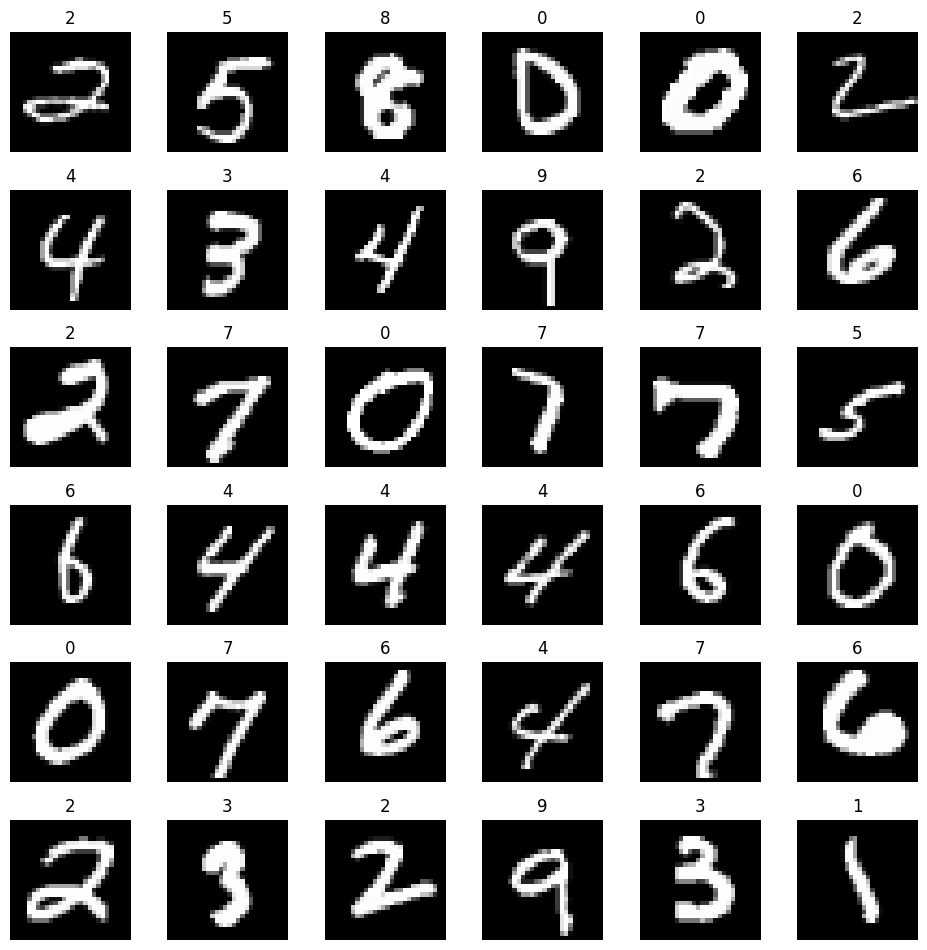

In [14]:
h, w = 6, 6  # tamaño de la grilla
fig, axs = plt.subplots(h, w, figsize=(1.6*h, 1.6*w))

for i in range(h):
    for j in range(w):
        idx = np.random.randint(len(X_train))  # índice aleatorio
        img = X_train[idx].reshape(28, 28)  # redimensionar imagen
        label = np.argmax(y_train[idx])     # obtener etiqueta

        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title(str(label))
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

Hacemos una muestra aleatoria de los datos y sus etiquetas de nuestro set de datos de entrenamiento donde podemos ver que es un set de datos que contiene imagenes en blanco y negro de numeros del 0 al 9. **[PREGUNTAR PORQUE USA EL NP SET SEED]**

# Creación de red neuronal base(Adamax)

Para esta fase de experimentación, siendo que nuestros datos no tienen una gran dispersion ya que trabajan unicamente con 2 colores, se tomo la decision de utilizar los optimizadores de Adamax y Nadam, adamax siendo la mejora del optimizador adam que suele tener buen rendimiento en la mayoria de los casos y Nadam siendo el optimizador adam pero agregandole momentum. Esto nos permitira saber como se comporta nuestra red neuronal con un optimizador que posea momentum y nos permita optimizar los tiempos en los que ajusta los pesos.

en el caso de la funcion de perdida utilizaremos **categorical crossentropy** ya que es la que se comporta mejor con datos que esten en formato one hot enconding, en este caso nuestras clases estan formateadas de esa forma.

In [19]:
input_shape = X_train.shape[1]
labels_output = y_train.shape[1]
print(input_shape)
print(y_train.shape[1])
h1 = 512
h2 = 256
h3 = 128
h4 = 64

red_adamax = keras.Sequential(name="BaseNetwork")
red_adamax.add(keras.layers.Input(shape=(input_shape,), name='input_layer'))
red_adamax.add(keras.layers.Dense(h1, activation='relu', name='hide_layer1'))
red_adamax.add(keras.layers.Dense(h2, activation='relu', name='hide_layer2'))
red_adamax.add(keras.layers.Dense(h3, activation='relu', name='hide_layer3'))
red_adamax.add(keras.layers.Dense(h4, activation='relu', name='hide_layer4'))
red_adamax.add(keras.layers.Dense(labels_output, activation='softmax', name='output_layer'))

red_adamax.summary()

red_adamax.compile(
    loss='categorical_crossentropy',
    optimizer='adamax',
    metrics=['accuracy']
)

784
10


Model: "BaseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hide_layer1 (Dense)             │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer2 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer3 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer4 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 575,050 (2.19 MB)

 Trainable params: 575,050 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

En este caso se tomo la decision de utilizar unicamente la precisión (accuracy) ya que es la metrica mas relevente para la problematica presentada. El f1-score solo nos sera util si hay presente desbalance de clase y este no es el caso (informacion entregada por el negocio - docente).

la precision y recall se encargan de evaluar los falsos positivos y verdaderos positivos, siendo multi clase entregara un promedio, por lo que no se le dara una interpretacion muy diferente a la que se pueda sacar con el accuracy siendo que al no haber desbalance de clases nuestro accuracy no se vera afectado por sesgo en nuestros datos.

In [16]:
hist = red_adamax.fit(X_train, y_train,
        epochs=15,
        batch_size=10,
        validation_data=(X_test,y_test)
       )

Epoch 1/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 46s 7ms/step - accuracy: 0.8858 - loss: 0.3746 - val_accuracy: 0.9631 - val_loss: 0.1155
Epoch 2/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 44s 7ms/step - accuracy: 0.9705 - loss: 0.0954 - val_accuracy: 0.9749 - val_loss: 0.0768
Epoch 3/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.9822 - loss: 0.0570 - val_accuracy: 0.9770 - val_loss: 0.0718
Epoch 4/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.9879 - loss: 0.0392 - val_accuracy: 0.9798 - val_loss: 0.0679
Epoch 5/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.9911 - loss: 0.0275 - val_accuracy: 0.9783 - val_loss: 0.0729
Epoch 6/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 80s 7ms/step - accuracy: 0.9943 - loss: 0.0180 - val_accuracy: 0.9811 - val_loss: 0.0604
Epoch 7/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.9964 - loss: 0.0117 - val_accuracy: 0.9825 - val_loss: 0.0671
Epoch 8/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 84s 7ms/step - accuracy: 0.9976 - loss: 0

In [21]:
hist = red_adamax.fit(X_train, y_train,
        epochs=20,
        batch_size=10,
        validation_data=(X_test,y_test)
       )

Epoch 1/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.9715 - loss: 0.0952 - val_accuracy: 0.9746 - val_loss: 0.0802
Epoch 2/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.9818 - loss: 0.0589 - val_accuracy: 0.9800 - val_loss: 0.0664
Epoch 3/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9885 - loss: 0.0358 - val_accuracy: 0.9785 - val_loss: 0.0678
Epoch 4/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 85s 7ms/step - accuracy: 0.9928 - loss: 0.0252 - val_accuracy: 0.9800 - val_loss: 0.0722
Epoch 5/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 78s 7ms/step - accuracy: 0.9950 - loss: 0.0167 - val_accuracy: 0.9773 - val_loss: 0.0871
Epoch 6/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.9966 - loss: 0.0117 - val_accuracy: 0.9819 - val_loss: 0.0672
Epoch 7/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.9975 - loss: 0.0084 - val_accuracy: 0.9816 - val_loss: 0.0740
Epoch 8/20
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 82s 7ms/step - accuracy: 0.9984 - loss: 0

In [23]:
hist = red_adamax.fit(X_train, y_train,
        epochs=15,
        batch_size=20,
        validation_data=(X_test,y_test)
       )

Epoch 1/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 1.0000 - loss: 4.7599e-07 - val_accuracy: 0.9834 - val_loss: 0.1644
Epoch 2/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 1.0000 - loss: 1.4214e-05 - val_accuracy: 0.9828 - val_loss: 0.1792
Epoch 3/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 1.0000 - loss: 2.1371e-04 - val_accuracy: 0.9836 - val_loss: 0.1683
Epoch 4/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 1.0000 - loss: 5.3241e-05 - val_accuracy: 0.9823 - val_loss: 0.1721
Epoch 5/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 1.0000 - loss: 1.5385e-04 - val_accuracy: 0.9823 - val_loss: 0.1706
Epoch 6/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 1.0000 - loss: 1.6146e-05 - val_accuracy: 0.9841 - val_loss: 0.1735
Epoch 7/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 1.0000 - loss: 2.2433e-05 - val_accuracy: 0.9830 - val_loss: 0.1866
Epoch 8/15
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step 

In [22]:
hist = red_adamax.fit(X_train, y_train,
        epochs=20,
        batch_size=20,
        validation_data=(X_test,y_test)
       )

Epoch 1/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9999 - loss: 3.8627e-04 - val_accuracy: 0.9834 - val_loss: 0.1178
Epoch 2/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 1.0000 - loss: 2.4737e-05 - val_accuracy: 0.9825 - val_loss: 0.1242
Epoch 3/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 1.0000 - loss: 4.8055e-05 - val_accuracy: 0.9813 - val_loss: 0.1386
Epoch 4/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9999 - loss: 4.3241e-04 - val_accuracy: 0.9831 - val_loss: 0.1316
Epoch 5/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step - accuracy: 1.0000 - loss: 1.6340e-05 - val_accuracy: 0.9827 - val_loss: 0.1406
Epoch 6/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 1.0000 - loss: 8.7557e-05 - val_accuracy: 0.9827 - val_loss: 0.1477
Epoch 7/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 1.0000 - loss: 3.0437e-04 - val_accuracy: 0.9828 - val_loss: 0.1354
Epoch 8/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step 

# Creación de red neuronal base(Nadam)

In [17]:
input_shape = X_train.shape[1]
labels_output = y_train.shape[1]
print(input_shape)
print(y_train.shape[1])
h1 = 512
h2 = 256
h3 = 128
h4 = 64

red_nadam = keras.Sequential(name="BaseNetwork")
red_nadam.add(keras.layers.Input(shape=(input_shape,), name='input_layer'))
red_nadam.add(keras.layers.Dense(h1, activation='relu', name='hide_layer1'))
red_nadam.add(keras.layers.Dense(h2, activation='relu', name='hide_layer2'))
red_nadam.add(keras.layers.Dense(h3, activation='relu', name='hide_layer3'))
red_nadam.add(keras.layers.Dense(h4, activation='relu', name='hide_layer4'))
red_nadam.add(keras.layers.Dense(labels_output, activation='softmax', name='output_layer'))

red_nadam.summary()

red_nadam.compile(
    loss='categorical_crossentropy',
    optimizer='adamax',
    metrics=['accuracy']
)

784
10


Model: "BaseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hide_layer1 (Dense)             │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer2 (Dense)             │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer3 (Dense)             │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hide_layer4 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 575,050 (2.19 MB)

 Trainable params: 575,050 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
hist = red_nadam.fit(X_train, y_train,
        epochs=15,
        batch_size=10,
        validation_data=(X_test,y_test)
       )

Epoch 1/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.8866 - loss: 0.3824 - val_accuracy: 0.9622 - val_loss: 0.1225
Epoch 2/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.9699 - loss: 0.0968 - val_accuracy: 0.9736 - val_loss: 0.0816
Epoch 3/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.9824 - loss: 0.0578 - val_accuracy: 0.9794 - val_loss: 0.0706
Epoch 4/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9885 - loss: 0.0380 - val_accuracy: 0.9769 - val_loss: 0.0774
Epoch 5/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 81s 7ms/step - accuracy: 0.9925 - loss: 0.0263 - val_accuracy: 0.9782 - val_loss: 0.0732
Epoch 6/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - accuracy: 0.9956 - loss: 0.0160 - val_accuracy: 0.9813 - val_loss: 0.0671
Epoch 7/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 43s 7ms/step - accuracy: 0.9965 - loss: 0.0121 - val_accuracy: 0.9818 - val_loss: 0.0739
Epoch 8/15
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - accuracy: 0.9977 - loss: 0